In [36]:
import os
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import open3d as o3d
import torch
import numpy as np
import torchvision
from d2l import torch as d2l
print("当前工作目录是：", os.getcwd())
voxel_size=0.008 
dev = 'cuda'
dim=[99,99,99]
def load_data(path):
    #读入
    data = o3d.io.read_point_cloud(path)
    vg = o3d.geometry.VoxelGrid.create_from_point_cloud(data, voxel_size)
    #o3d.visualization.draw_geometries([vg])
    #体素化
    coords_np = np.asarray([v.grid_index for v in vg.get_voxels()], dtype=np.float32)
    color_np=np.asarray([v.color for v in vg.get_voxels()], dtype=np.float32)

    #获得坐标和颜色
    coords = torch.from_numpy(coords_np).to(dev)
    color=torch.from_numpy(color_np).to(dev)
    mins = torch.from_numpy(coords_np.min(0)).to(coords)
    maxs = torch.from_numpy(coords_np.max(0)).to(coords)
    dims = maxs - mins + 1 
    dims=dims.cpu().numpy().astype(int)

    #创建稠密网格以便FFT
    dense = torch.zeros((4,dims[0], dims[1], dims[2]), device=dev)
    x_idx = (coords - mins)[..., 0].long()
    y_idx = (coords - mins)[..., 1].long()
    z_idx = (coords - mins)[..., 2].long()
    dense[0,x_idx, y_idx, z_idx] = 1.0
    dense[1:4,x_idx, y_idx, z_idx]=color.T
    return dense

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file,transform=torchvision.transforms.ToTensor()):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform=transform
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path =os.path.join("D:\\","vscodefiles","python","DensePoint",self.img_labels.iloc[idx,0])
        dense=load_data(img_path)
        #print(f'shapedense:{dense.shape}')
        F = torch.fft.fftn(dense, dim=(1,2,3),s=dim)
        amp=torch.abs(F)
        #print(f'shapeF:{F.shape}')
        phase=torch.angle(F)
        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)
        return amp,phase,label

train_data=CustomImageDataset('DensePoint\\train.csv')
test_data=CustomImageDataset('DensePoint\\test.csv')

train_iter=DataLoader(train_data,batch_size=8,shuffle=True,)
test_iter=DataLoader(test_data,batch_size=8,shuffle=True,)
""" train_iter=DataLoader(train_data,batch_size=16,shuffle=False)
test_iter=DataLoader(test_data,batch_size=16,shuffle=False) """
""" for i in range(100):
    amp,phase,label = next(iter(train_iter))
    #print(f'shapeamp:{phase.shape}')
    if(i==0):
        break """

当前工作目录是： d:\vscodefiles\python


" for i in range(100):\n    amp,phase,label = next(iter(train_iter))\n    #print(f'shapeamp:{phase.shape}')\n    if(i==0):\n        break "

In [37]:
from torch import nn
#nn会自动忽略掉第一个维度，把第二个维度作为通道维

class NET(nn.Module):
    def __init__(self): #输入附加条件，这里没有
        super().__init__()
        self.net_pre=nn.Sequential(nn.Conv3d(in_channels=4,out_channels=8,kernel_size=5),nn.LeakyReLU(0.1),
                  nn.Conv3d(in_channels=8,out_channels=16,kernel_size=5,padding=1),nn.LeakyReLU(0.1),
                  nn.MaxPool3d(kernel_size=7,stride=2),
                  nn.Conv3d(in_channels=16,out_channels=32,kernel_size=5,padding=1),nn.LeakyReLU(0.1),
                  nn.MaxPool3d(kernel_size=5,stride=2),
                  nn.Conv3d(in_channels=32,out_channels=32,kernel_size=7),nn.LeakyReLU(0.1),
                  nn.MaxPool3d(kernel_size=7,stride=2),nn.Flatten(),
                  nn.Linear(2048,128))
        self.net_concat=nn.Sequential(nn.Linear(256,128),nn.ReLU(),nn.BatchNorm1d(num_features=128),nn.Dropout(0.3),nn.Linear(128,16))
    def forward(self, amp, phase):
        amp  = self.net_pre(amp)        
        phase  = self.net_pre(phase)       
        f_cat  = torch.cat([amp,phase], dim=1)   
        y_hat    = self.net_concat(f_cat)     
        return y_hat  
net=NET()
x=torch.randn(8,4,99,99,99)
y=torch.randn(8,4,99,99,99)
z=net(x,y)
print(z.shape)

torch.Size([8, 16])


In [38]:
def evaluate_accuracy_gpu(net, data_iter, device='cuda'):
    """Evaluate accuracy for a two-branch network on GPU."""
    if isinstance(net, nn.Module):
        net.eval()                                 # 评估模式
        if device is None:
            device = next(net.parameters()).device

    metric = d2l.Accumulator(2)                    # correct, total
    with torch.no_grad():
        for amp, phase, y in data_iter:            # ← 3 个元素
            amp   = amp.to(device, non_blocking=True);
            phase = phase.to(device, non_blocking=True);
            y     = y.to(device, non_blocking=True);

            y_hat = net(amp, phase)                # 前向
            metric.add(d2l.accuracy(y_hat, y), y.numel())

    return metric[0] / metric[1]


def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6).

    Defined in :numref:`sec_utils`"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv3d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (amp,phase, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            amp,phase, y = amp.to(device),phase.to(device), y.to(device)
            y_hat = net(amp,phase)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * amp.shape[0], d2l.accuracy(y_hat, y), amp.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
            f'test acc {test_acc:.3f}')
        print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
            f'on {str(device)}')

loss 0.310, train acc 1.000, test acc 0.900
5.5 examples/sec on cuda:0


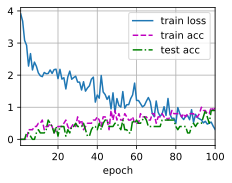

In [39]:
train_ch6(net, train_iter, test_iter,100, 0.001, d2l.try_gpu());